# Loudness

Loudness comparison according to the [ITU-R BS.1770-4](https://github.com/csteinmetz1/pyloudnorm) loudness algorithm implementation.

In [231]:
import sys
sys.path.append('..')

In [232]:
import warnings
warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [233]:
import IPython.display as display
import librosa
import matplotlib.pyplot as plot
import numpy as np

from philharmonia import dataframe, datafile

In [234]:
import pyloudnorm

meter = None

def loudness(sample):

    x, sr = librosa.load(datafile(sample.file), sr=None, mono=True)

    global meter
    meter = meter or pyloudnorm.Meter(sr, block_size=100e-3)

    db = meter.integrated_loudness(x)

    return int(db)

In [235]:
query = [
    "percussion==False",
    # "note == 'C'",
    "style == 'normal'",
    "length == '1'",
]

filter = ['file', 'instrument', 'note', 'octave', 'pitch', 'dynamic']
sort = ['pitch', 'dynamic', 'loudness']

data = dataframe().query(' & '.join(query)).filter(filter)

data['loudness'] = data.apply(lambda sample: loudness(sample), axis=1)

data = data.sort_values(sort)

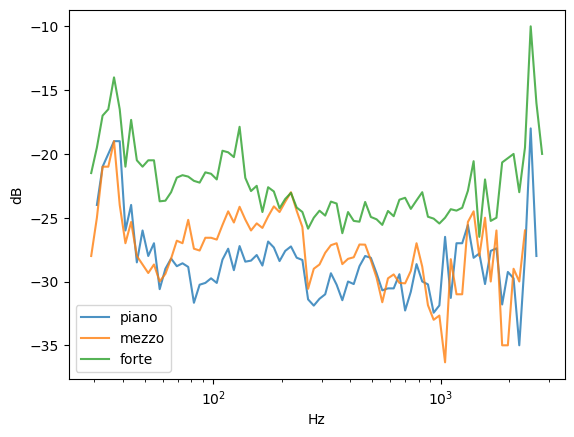

In [236]:
dynamics = {
    dynamic: data[data.dynamic.str.startswith(dynamic[:-1])]
    for dynamic in ['piano', 'mezzo', 'forte']
}

for dynamic in dynamics:

    mean = dynamics[dynamic].groupby(['pitch']).mean().reset_index()

    x = mean.pitch.tolist()
    y = mean.loudness.tolist()

    plot.plot(x, y, label=dynamic, alpha=0.8)

plot.legend();
plot.xscale('log');
plot.xlabel('Hz');
plot.ylabel('dB');

In [240]:
display.HTML(data.head(100).to_html())

,file,instrument,note,octave,pitch,dynamic,loudness
7882,contrabassoon/contrabassoon_As0_1_forte_normal.mp3,contrabassoon,A#,0.0,29.14,forte,-24
7995,contrabassoon/contrabassoon_As0_1_fortissimo_normal.mp3,contrabassoon,A#,0.0,29.14,fortissimo,-19
7905,contrabassoon/contrabassoon_As0_1_mezzo-forte_normal.mp3,contrabassoon,A#,0.0,29.14,mezzo-forte,-28
8442,contrabassoon/contrabassoon_B0_1_forte_normal.mp3,contrabassoon,B,0.0,30.87,forte,-20
8382,contrabassoon/contrabassoon_B0_1_fortissimo_normal.mp3,contrabassoon,B,0.0,30.87,fortissimo,-19
7898,contrabassoon/contrabassoon_B0_1_mezzo-forte_normal.mp3,contrabassoon,B,0.0,30.87,mezzo-forte,-25
8286,contrabassoon/contrabassoon_B0_1_piano_normal.mp3,contrabassoon,B,0.0,30.87,piano,-24
7994,contrabassoon/contrabassoon_C1_1_forte_normal.mp3,contrabassoon,C,1.0,32.70,forte,-18
8166,contrabassoon/contrabassoon_C1_1_fortissimo_normal.mp3,contrabassoon,C,1.0,32.70,fortissimo,-16
8263,contrabassoon/contrabassoon_C1_1_mezzo-forte_normal.mp3,contrabassoon,C,1.0,32.70,mezzo-forte,-21
